<a href="https://colab.research.google.com/github/sajacaros/optiver/blob/main/sajacaros/03_model_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qqq timm torchmetrics torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.1 MB/s eta 0:00:00


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
# warnings.filterwarnings(action='default')

In [ ]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/optiver/'
else:
    data_path = '../data/'

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(data_path+'train.csv')
test_df = pd.read_csv(data_path+'test.csv')
submission_df = pd.read_csv(data_path+'sample_submission.csv')
target_df = pd.read_csv(data_path+'revealed_targets.csv')

# <추가적인 피쳐 정보>
* stock: 200개
* 피쳐수: 16개 + 타겟 1개
* train 기간: 0~480, 481일
* seconds_in_bucket
    * 0~540 (10씩 증가)
    * stock당 하루 55개의 data가 쌓임
    * 300부터는 far_price와 near_price가 존재함
* 일부 stock의 경우 데이터가 누락됨
    * 종목당  26,455`(=55*481)` 개의 데이터가 있어야 함
    * 11개의 종목이 데이터가 누락됨(아래 그림 참고)
    * 총 length가 5,291,000`(=200*55*541)`이 되어야 하지만 누락건수로 인해 5,237,980이 됨

In [ ]:
# null 값 처리
train_df['far_price'] = train_df['far_price'].fillna(0)
train_df['near_price'] = train_df['near_price'].fillna(1)

In [ ]:
train_df.loc[train_df.isnull().any(axis=1)] # 220

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,0.0,1.0,NaN,0.00,NaN,0.00,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,0.0,1.0,NaN,0.00,NaN,0.00,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,0.0,1.0,NaN,0.00,NaN,0.00,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,0.0,1.0,NaN,0.00,NaN,0.00,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,0.0,1.0,NaN,0.00,NaN,0.00,NaN,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774999,19,438,500,NaN,-1,NaN,NaN,0.0,1.0,NaN,115491.18,NaN,1990.10,NaN,3.319979,24140,438_500_19
4775199,19,438,510,NaN,-1,NaN,NaN,0.0,1.0,NaN,189040.50,NaN,26283.84,NaN,-5.049705,24141,438_510_19
4775399,19,438,520,NaN,-1,NaN,NaN,0.0,1.0,NaN,1392.93,NaN,43799.80,NaN,-0.110269,24142,438_520_19
4775599,19,438,530,NaN,-1,NaN,NaN,0.0,1.0,NaN,13531.32,NaN,26881.20,NaN,-1.689792,24143,438_530_19


In [ ]:
cols_group_by = ['date_id', 'seconds_in_bucket']
cols_fill_nan = [
    'imbalance_size', 'reference_price', 'matched_size', 'wap',
    'bid_price', 'bid_size', 'ask_price', 'ask_size',
    'stock_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag']
train_grouped_median = train_df.groupby(cols_group_by)[cols_fill_nan].transform('median')
train_df[cols_fill_nan] = train_df[cols_fill_nan].fillna(train_grouped_median)
train_df.loc[train_df.isnull().any(axis=1)] # target 88

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,1381981.10,0,0.999950,9723622.86,0.0,1.0,0.999688,0.0,1.000242,0.0,1.000000,NaN,1925,35_0_131
369700,131,35,10,1371886.54,0,1.000252,9961197.49,0.0,1.0,0.999969,0.0,1.000485,0.0,1.000223,NaN,1926,35_10_131
369892,131,35,20,1331838.54,0,1.000122,9999133.11,0.0,1.0,0.999883,0.0,1.000328,0.0,1.000149,NaN,1927,35_20_131
370084,131,35,30,1350584.58,0,0.999910,10133596.07,0.0,1.0,0.999757,0.0,1.000186,0.0,0.999971,NaN,1928,35_30_131
370276,131,35,40,1327284.70,0,0.999926,10133596.07,0.0,1.0,0.999758,0.0,1.000203,0.0,0.999984,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225338,158,388,510,339056.84,0,1.001074,19640140.62,0.0,1.0,1.000867,0.0,1.001250,0.0,1.001027,NaN,21391,388_510_158
4225538,158,388,520,437746.70,0,1.001183,19767348.90,0.0,1.0,1.001007,0.0,1.001290,0.0,1.001163,NaN,21392,388_520_158
4225738,158,388,530,483535.46,0,1.000994,19800447.29,0.0,1.0,1.000905,0.0,1.001187,0.0,1.001032,NaN,21393,388_530_158
4225938,158,388,540,453894.62,0,1.000989,20020720.89,0.0,1.0,1.000824,0.0,1.001024,0.0,1.000911,NaN,21394,388_540_158


In [ ]:
train_df = train_df.dropna()
train_df.shape

(5237892, 17)

In [ ]:
selected_features = [
    'date_id', 'seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 'wap',
    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size',
    'stock_id', 'imbalance_buy_sell_flag']

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
X_all = scaler.fit_transform(train_df[selected_features].values)
# X_all = train_df[selected_features].values
y_all = train_df[['target']].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import transforms

In [ ]:
# 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid))

In [ ]:
batch_size=4096
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
input_size = len(selected_features)
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=input_size*5) # input => hidden1
        self.fc2 = nn.Linear(in_features=input_size*5, out_features=input_size*3) # hidden1 => hidden2
        self.fc3 = nn.Linear(in_features=input_size*3, out_features=1) # hidden3 => output
        self.relu = nn.ReLU() # activation layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model().to(device)
model

Model(
  (fc1): Linear(in_features=14, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# 손실 함수
criterion = nn.L1Loss()

In [ ]:
# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
# # 스케쥴러
# import math
# from torch.optim.lr_scheduler import _LRScheduler

# class CosineAnnealingWarmUpRestarts(_LRScheduler):
#     def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
#         if T_0 <= 0 or not isinstance(T_0, int):
#             raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
#         if T_mult < 1 or not isinstance(T_mult, int):
#             raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
#         if T_up < 0 or not isinstance(T_up, int):
#             raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
#         self.T_0 = T_0
#         self.T_mult = T_mult
#         self.base_eta_max = eta_max
#         self.eta_max = eta_max
#         self.T_up = T_up
#         self.T_i = T_0
#         self.gamma = gamma
#         self.cycle = 0
#         self.T_cur = last_epoch
#         super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         if self.T_cur == -1:
#             return self.base_lrs
#         elif self.T_cur < self.T_up:
#             return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
#         else:
#             return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
#                     for base_lr in self.base_lrs]

#     def step(self, epoch=None):
#         if epoch is None:
#             epoch = self.last_epoch + 1
#             self.T_cur = self.T_cur + 1
#             if self.T_cur >= self.T_i:
#                 self.cycle += 1
#                 self.T_cur = self.T_cur - self.T_i
#                 self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
#         else:
#             if epoch >= self.T_0:
#                 if self.T_mult == 1:
#                     self.T_cur = epoch % self.T_0
#                     self.cycle = epoch // self.T_0
#                 else:
#                     n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
#                     self.cycle = n
#                     self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
#                     self.T_i = self.T_0 * self.T_mult ** (n)
#             else:
#                 self.T_i = self.T_0
#                 self.T_cur = epoch

#         self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
#         self.last_epoch = math.floor(epoch)
#         for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
#             param_group['lr'] = lr

# lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=2, eta_max=0.1, T_up=10, gamma=0.5)
# lr_scheduler

In [ ]:
# Scheduler
from torch.optim import lr_scheduler

lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=20,
    T_mult=1,
    eta_min=1e-6
)
lr_scheduler

In [ ]:
from tqdm.auto import tqdm
epochs = 100

train_epoch_loss = []
valid_epoch_loss = []
for epoch in range(epochs):

    train_iter_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    model.train()
    for idx, (stocks, movements) in bar:
        # with torch.autocast(device_type='cuda', dtype=torch.float64):
        stocks = stocks.to(device)
        movements = movements.to(device)
        outputs = model(stocks)
        # print(outputs.shape, movements.shape)
        loss = criterion(outputs, movements)
        train_iter_loss.append(loss.item())
        optimizer.zero_grad() # 기울기 초기화
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()
        bar.set_postfix(
            Epoch = epoch,
            Current_loss = loss.item(),
            Train_loss = sum(train_iter_loss)/(idx+1),
            LR = optimizer.param_groups[0]['lr'],
        )
    print(f'Epoch [{epoch+1}/{epochs}] - Train loss : {sum(train_iter_loss)/len(train_loader):.4f}')
    train_epoch_loss.append(sum(train_iter_loss)/len(train_loader))

    model.eval()
    valid_iter_loss = []
    bar = tqdm(enumerate(valid_loader), total = len(valid_loader), desc='Valid Loop')
    for idx, (stocks, movements) in bar:
        # with torch.autocast(device_type='cuda', dtype=torch.float16):
        with torch.no_grad():
            stocks = stocks.to(device)
            movements = movements.to(device)
            outputs = model(stocks)
            loss = criterion(outputs, movements)
            valid_iter_loss.append(loss.item())
            bar.set_postfix(
              Epoch = epoch,
              Current_loss = loss.item(),
              Valid_loss = sum(valid_iter_loss)/(idx+1),
              LR = optimizer.param_groups[0]['lr'],
          )
    print(f'Epoch [{epoch+1}/{epochs}] - Valid loss : {sum(valid_iter_loss)/len(valid_loader):.4f}')
    valid_epoch_loss.append(sum(valid_iter_loss)/len(valid_loader))

Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [1/100] - Train loss : 6.3201


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [1/100] - Valid loss : 6.3005


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [2/100] - Train loss : 6.3020


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [2/100] - Valid loss : 6.2927


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [3/100] - Train loss : 6.2953


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [3/100] - Valid loss : 6.2869


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [4/100] - Train loss : 6.2910


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [4/100] - Valid loss : 6.2847


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [5/100] - Train loss : 6.2879


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [5/100] - Valid loss : 6.2842


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [6/100] - Train loss : 6.2856


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [6/100] - Valid loss : 6.2819


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [7/100] - Train loss : 6.2835


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [7/100] - Valid loss : 6.2819


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [8/100] - Train loss : 6.2816


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [8/100] - Valid loss : 6.2814


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [9/100] - Train loss : 6.2798


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [9/100] - Valid loss : 6.2796


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [10/100] - Train loss : 6.2784


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [10/100] - Valid loss : 6.2779


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [11/100] - Train loss : 6.2769


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [11/100] - Valid loss : 6.2781


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [12/100] - Train loss : 6.2761


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [12/100] - Valid loss : 6.2747


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [13/100] - Train loss : 6.2747


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [13/100] - Valid loss : 6.2743


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [14/100] - Train loss : 6.2738


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [14/100] - Valid loss : 6.2745


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [15/100] - Train loss : 6.2726


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [15/100] - Valid loss : 6.2742


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [16/100] - Train loss : 6.2718


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [16/100] - Valid loss : 6.2738


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [17/100] - Train loss : 6.2711


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [17/100] - Valid loss : 6.2722


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [18/100] - Train loss : 6.2704


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [18/100] - Valid loss : 6.2718


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [19/100] - Train loss : 6.2698


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [19/100] - Valid loss : 6.2716


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [20/100] - Train loss : 6.2692


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [20/100] - Valid loss : 6.2719


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [21/100] - Train loss : 6.2686


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [21/100] - Valid loss : 6.2713


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [22/100] - Train loss : 6.2682


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [22/100] - Valid loss : 6.2722


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [23/100] - Train loss : 6.2674


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [23/100] - Valid loss : 6.2713


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [24/100] - Train loss : 6.2668


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [24/100] - Valid loss : 6.2704


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [25/100] - Train loss : 6.2663


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [25/100] - Valid loss : 6.2709


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [26/100] - Train loss : 6.2659


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [26/100] - Valid loss : 6.2699


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [27/100] - Train loss : 6.2654


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [27/100] - Valid loss : 6.2697


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [28/100] - Train loss : 6.2648


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [28/100] - Valid loss : 6.2692


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [29/100] - Train loss : 6.2645


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [29/100] - Valid loss : 6.2690


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [30/100] - Train loss : 6.2641


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [30/100] - Valid loss : 6.2677


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [31/100] - Train loss : 6.2638


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [31/100] - Valid loss : 6.2682


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [32/100] - Train loss : 6.2632


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [32/100] - Valid loss : 6.2693


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [33/100] - Train loss : 6.2629


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [33/100] - Valid loss : 6.2688


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [34/100] - Train loss : 6.2626


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [34/100] - Valid loss : 6.2679


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [35/100] - Train loss : 6.2624


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [35/100] - Valid loss : 6.2678


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [36/100] - Train loss : 6.2622


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [36/100] - Valid loss : 6.2682


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [37/100] - Train loss : 6.2618


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [37/100] - Valid loss : 6.2673


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [38/100] - Train loss : 6.2617


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [38/100] - Valid loss : 6.2674


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [39/100] - Train loss : 6.2612


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [39/100] - Valid loss : 6.2658


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [40/100] - Train loss : 6.2610


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [40/100] - Valid loss : 6.2663


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [41/100] - Train loss : 6.2607


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [41/100] - Valid loss : 6.2648


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [42/100] - Train loss : 6.2605


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [42/100] - Valid loss : 6.2666


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [43/100] - Train loss : 6.2603


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [43/100] - Valid loss : 6.2658


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [44/100] - Train loss : 6.2600


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [44/100] - Valid loss : 6.2660


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [45/100] - Train loss : 6.2598


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [45/100] - Valid loss : 6.2643


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [46/100] - Train loss : 6.2596


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [46/100] - Valid loss : 6.2657


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [47/100] - Train loss : 6.2595


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [47/100] - Valid loss : 6.2644


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [48/100] - Train loss : 6.2593


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [48/100] - Valid loss : 6.2649


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [49/100] - Train loss : 6.2590


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [49/100] - Valid loss : 6.2651


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [50/100] - Train loss : 6.2588


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [50/100] - Valid loss : 6.2646


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [51/100] - Train loss : 6.2586


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [51/100] - Valid loss : 6.2636


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [52/100] - Train loss : 6.2585


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [52/100] - Valid loss : 6.2640


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [53/100] - Train loss : 6.2582


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [53/100] - Valid loss : 6.2633


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [54/100] - Train loss : 6.2582


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [54/100] - Valid loss : 6.2636


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [55/100] - Train loss : 6.2578


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [55/100] - Valid loss : 6.2645


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [56/100] - Train loss : 6.2578


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [56/100] - Valid loss : 6.2643


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [57/100] - Train loss : 6.2576


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [57/100] - Valid loss : 6.2630


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [58/100] - Train loss : 6.2575


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [58/100] - Valid loss : 6.2638


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [59/100] - Train loss : 6.2574


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [59/100] - Valid loss : 6.2633


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [60/100] - Train loss : 6.2572


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [60/100] - Valid loss : 6.2623


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [61/100] - Train loss : 6.2571


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [61/100] - Valid loss : 6.2639


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [62/100] - Train loss : 6.2570


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [62/100] - Valid loss : 6.2640


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [63/100] - Train loss : 6.2571


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [63/100] - Valid loss : 6.2634


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [64/100] - Train loss : 6.2568


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [64/100] - Valid loss : 6.2629


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [65/100] - Train loss : 6.2565


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [65/100] - Valid loss : 6.2622


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [66/100] - Train loss : 6.2563


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [66/100] - Valid loss : 6.2632


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [67/100] - Train loss : 6.2565


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

Epoch [67/100] - Valid loss : 6.2624


Train Loop:   0%|          | 0/1023 [00:00<?, ?it/s]

Epoch [68/100] - Train loss : 6.2563


Valid Loop:   0%|          | 0/255 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
np.argmin(train_epoch_loss), min(train_epoch_loss), np.argmin(valid_epoch_loss), min(valid_epoch_loss)

(67, 6.256317171766145, 64, 6.262206414166619)

<Axes: >

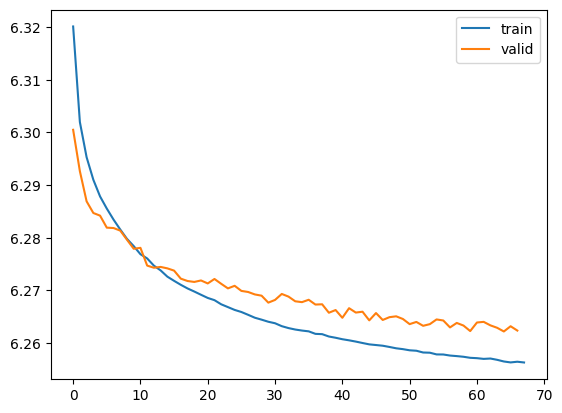

In [ ]:
sns.lineplot(train_epoch_loss, label='train')
sns.lineplot(valid_epoch_loss, label='valid')